# Latam Airlines' Data Scientist Challenge Solution

- Author: Javier Welch (welch.javier[at]gmail.com)
- Date: January 13th, 2023

### Contents

0. Imports and Preprocessing
1. Question 1: How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?
2. Question 2: Generate additional columns and export them to a CSV file.
3. Question 3: What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?What variables would you expect to have the most influence in predicting delays?
4. Question 4: Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
5. Question 5: Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in the prediction task? How could you improve the Performance?

## 0. Imports and Preprocessing

In [79]:
# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from utils import *
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

#Plot configs
%matplotlib inline
sns.set(rc={"figure.figsize":(10, 6)})

#Supress warnings
#Has to be done this way to supress warnings while ussing multiprocessing...
import sys
import os
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [80]:
# Data import
data = pd.read_csv('../data/dataset_SCL.csv')

In [81]:
#Check data structure
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [82]:
#Check data types and non-nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [83]:
#Check for extra missind values
data.isna().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

There are 2 date columns that should be parsed ("Fecha-I" & "Fecha-O") and a missing value in the "Vlo-O" column.

In [84]:
#Parse Fecha columns
date_columns = ["Fecha-I", "Fecha-O"]
for col in date_columns:
    data[col] = pd.to_datetime(data[col])

In [85]:
#Identify missing value
#Flight Operation Number can be identified by 
row_missing_value = data[data['Vlo-O'].isna()]
row_missing_value

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


In [86]:
#Missing Flight Operation Number corresponds to a LAW flight from SCEL to SPJC scheduled for Thursdays at 11:00, let's check if there's a matching record
matching_records = data[(data['Fecha-I'].dt.hour == row_missing_value['Fecha-I'].dt.hour.iloc[0]) 
    & (data['Emp-I'] == row_missing_value['Emp-I'].iloc[0]) 
    & (data['Ori-O'] == row_missing_value['Ori-O'].iloc[0]) 
    & (data['Des-O'] == row_missing_value['Des-O'].iloc[0]) 
    & (data['DIANOM'] == row_missing_value['DIANOM'].iloc[0]) 
    & ~(data['Vlo-O'].isna())]

matching_records['Vlo-O'].value_counts()

200    26
Name: Vlo-O, dtype: int64

In [87]:
#Flight Operation Number was supposed to be 200, let's patch it
data.loc[row_missing_value.index, 'Vlo-O'] = matching_records['Vlo-O'].value_counts().index[0]
data.loc[row_missing_value.index, 'Vlo-O']

6068    200
Name: Vlo-O, dtype: object

### 1. Question 1: How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

Firstly, it is impotant to note that all flights in the dataset depart from Santiago (SCL). From this starting point we can start drilling down using different criteria to analyze the data:
- There are 23 different companies operating flights departing from SCL:
    - However, there are only 4 airlines operating domestic flights, with Grupo LATAM being the market leader having operated 64% of all domestic flights, followed far behind by Sky Airline with a share of 31%. 

    - International flights incorporate more competitors but Grupo LATAM still emerges as the top operator with a share of 55% of flights, while all other operators had shares of less than 10%. 

    - Most operators fly to under 3 destinations, with the only exceptions being Chilean Operators. This makes sense since only Chilean companies are allowed to fly within Chile and most Foreign Operators focus on carrying passengers to their hubs (Buenos Aires for Aerolineas Argentinas, Atlanta for Delta Airlines, Houston for United Airlines, etc.)

- Looking at the distribution of flights by destination, we can see that the there are 62 unique destinations for flights departing from SCL:
    - In spite of that, the number of flights by destination is fairly concentrated, with the top 10 destinations representing 63% of the total flight volume. The top 5 destinations are Buenos Aires, Antofagasta, Lima, Calama and Puerto Montt.

    - Most destinations are visited by just one operator, while only 6 are visited by 4 or more operators, being Lima the most popular destination. 
    
- When inspecting the data by kind of flight (domestic v/s international), we see that domestics flights represent 54% of the total flight volume:
    
    - Analyzing the yearly seasonality of domestic and international flights we discover that both kinds of flights have peaks during the summer and July (high-seasons) but domestic flights experience sharper declines during the first semesters off-season, suggesting that the share of vacational travelers is higher throughout the year for domestic flights when compared to international flights. 
    
    - Digging deeper into weekly and daily seasonality, we find that there is a sharp decline in domestic flight numbers during Saturdays and that they tend to concentrate in the 6:00-8:00 and 17:00-19:00 periods, indicating that there is a larger share of work related flights. 
    
    - On the other hand, international flights tend to have a flatter weekly distribution but trending higher during weekends. Lastly, international flights have a larger proportion of nighttime flights due to their longer duration.

- When looking at selected destinations (namely, Buenos Aires, Antofagasta, Calama, Puerto Montt, Miami & Madrid), we confirm our previous findings for domestic destinations but with a marked distinction between cities located in the North and South of Chile, being the first ones more affected by their high share of work related flights, following the yearly pattern of mining activity (upward trending during the second semester).

- Looking at international destinations:
    - We see that flights to Buenos Aires are fairly stable during the year and week and probably cater to working and vacational travelers with peaks during the morning (6:00-9:00), at 16:00 (return of Argentinian workers and pick up of Chilean workers around 18:00-19:00) and at 21:00 (return of Argentinian vacationers and pick up of Chilean vacationers around 23:00). 
    
    - Flights to Miami trend higher during summer and typically depart between 21:00 and 23:00 in order to arrive early in ther morning, while flights to Madrid tend to peak during the European summer and have two hourly clusters: around noon for European flights returning home (operated by Iberia) and around 19:00 for flights whose home base is Chile (operated by Grupo LATAM).

In [88]:
#Flight origin, all flights depart from Santiago
data['SIGLAORI'].value_counts()

Santiago    68206
Name: SIGLAORI, dtype: int64

In [89]:
#Number of airlines
data['OPERA'].nunique()

23

In [90]:
#Share of flights by airline and kind
pivot_airlines_kind = pd.pivot_table(data = data, values = 'DIA', index = ['OPERA'], columns=['TIPOVUELO'], aggfunc = 'count', fill_value = 0)
pivot_airlines_kind = pivot_airlines_kind/pivot_airlines_kind.sum()*100
pivot_airlines_kind = pivot_airlines_kind.reset_index()

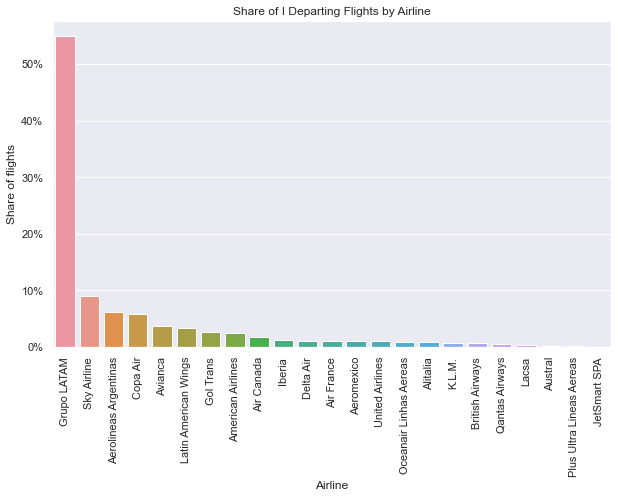

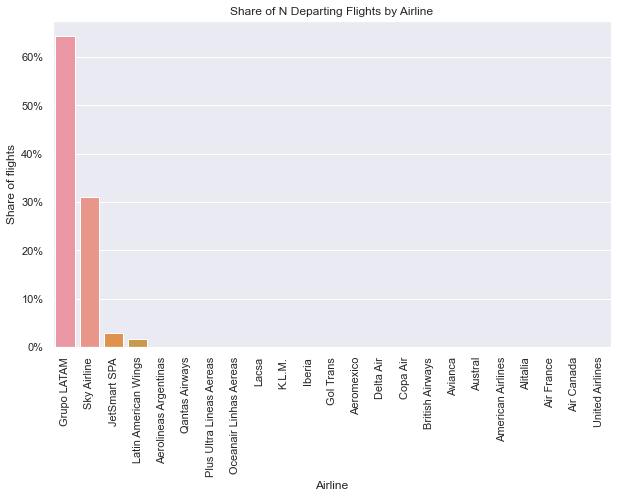

In [91]:
#Plot share of flights by airline and kind
for kind in ['I', 'N']:
    fig = sns.barplot(data=pivot_airlines_kind.sort_values(kind, ascending=False), x='OPERA', y=kind)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    fig.yaxis.set_major_formatter(mtick.PercentFormatter())
    fig.set_title(f"Share of {kind} Departing Flights by Airline")
    fig.set_ylabel("Share of flights")
    fig.set_xlabel("Airline")
    plt.show()

In [92]:
#Unique Flight destinations
data['SIGLADES'].nunique()

62

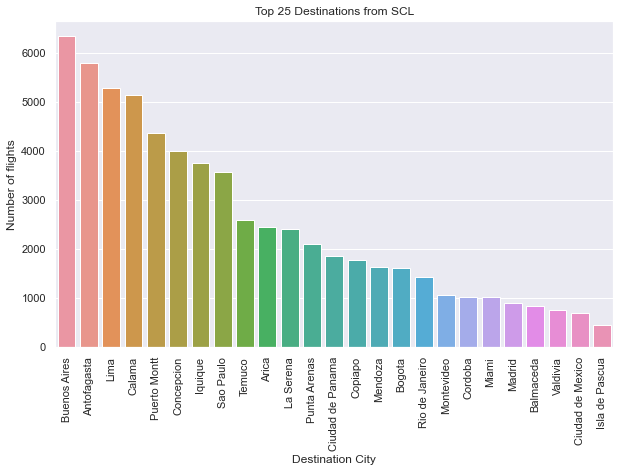

In [93]:
#Plot number of Flights by destination
fig = sns.countplot(data=data, 
            x = 'SIGLADES',
            order = data['SIGLADES'].value_counts().iloc[:25].index)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set_title("Top 25 Destinations from SCL")
fig.set_ylabel("Number of flights")
fig.set_xlabel("Destination City")
plt.show()

In [94]:
#Cumulative share of flights, fairly concentrated, 10 destinations represent nearly 70% of outbound flights
vc_destinations = data['SIGLADES'].value_counts(normalize = True)
vc_destinations = vc_destinations.cumsum()
vc_destinations = vc_destinations.reset_index(drop=True)
vc_destinations.head(15)


0     0.092880
1     0.177712
2     0.254978
3     0.330425
4     0.394305
5     0.452849
6     0.507785
7     0.560112
8     0.598071
9     0.633786
10    0.669120
11    0.699982
12    0.727106
13    0.753204
14    0.777028
Name: SIGLADES, dtype: float64

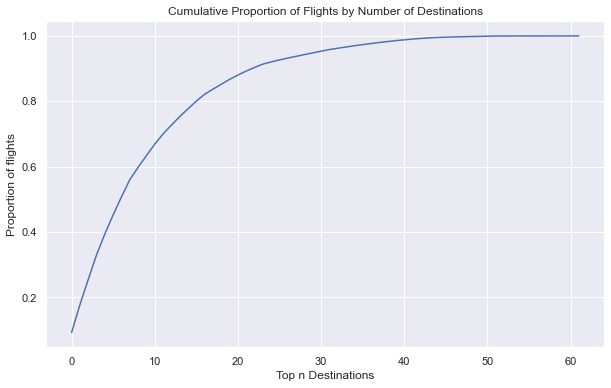

In [95]:
#Plot cumulative share of flight by destination
fig = sns.lineplot(data = vc_destinations)
fig.set_title('Cumulative Proportion of Flights by Number of Destinations')
fig.set_ylabel('Proportion of flights')
fig.set_xlabel('Top n Destinations')
plt.show()

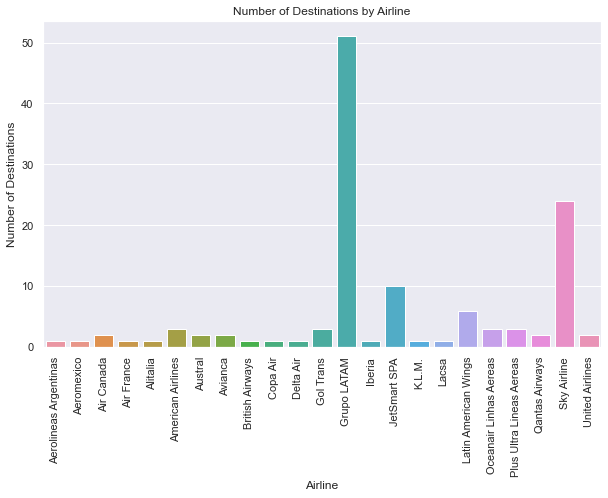

In [96]:
nunq_destinations_by_operator = data.groupby('OPERA',as_index = False).nunique()[['OPERA', 'SIGLADES']]
fig = sns.barplot(data = nunq_destinations_by_operator, x = 'OPERA', y='SIGLADES')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set_title("Number of Destinations by Airline")
fig.set_ylabel("Number of Destinations")
fig.set_xlabel("Airline")
plt.show()

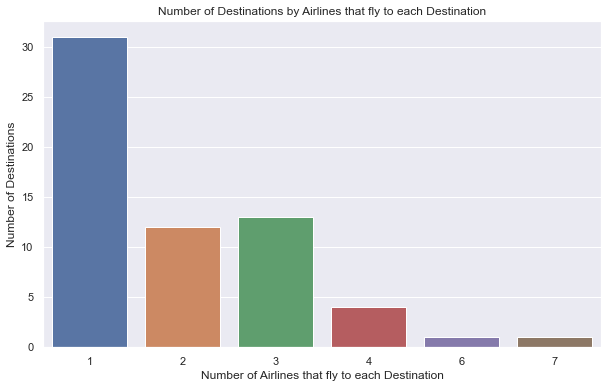

In [97]:
n_airlines_by_destination = data.groupby('SIGLADES',as_index = False).nunique()[['SIGLADES', 'OPERA']]['OPERA'].value_counts().reset_index()
fig = sns.barplot(data = n_airlines_by_destination, x = 'index', y='OPERA')
fig.set_title("Number of Destinations by Airlines that fly to each Destination")
fig.set_ylabel("Number of Destinations")
fig.set_xlabel("Number of Airlines that fly to each Destination")
plt.show()

In [98]:
#Share of flights by kind
vc_flight_kind = data['TIPOVUELO'].value_counts(normalize=True)
vc_flight_kind

N    0.541976
I    0.458024
Name: TIPOVUELO, dtype: float64

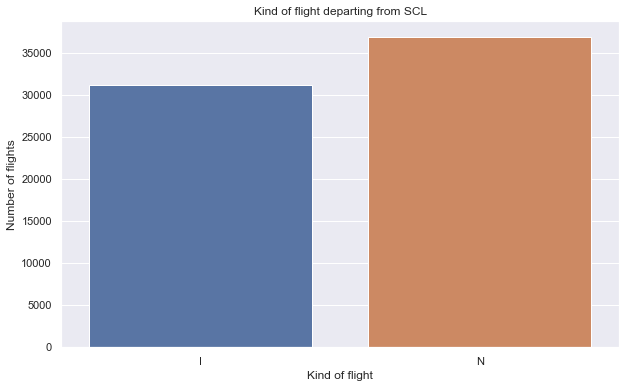

In [99]:
#Count of Domestic vs International Flights, not much difference overall
fig = sns.countplot(data = data, x= 'TIPOVUELO')
fig.set_title("Kind of flight departing from SCL")
fig.set_ylabel("Number of flights")
fig.set_xlabel("Kind of flight")
plt.show()

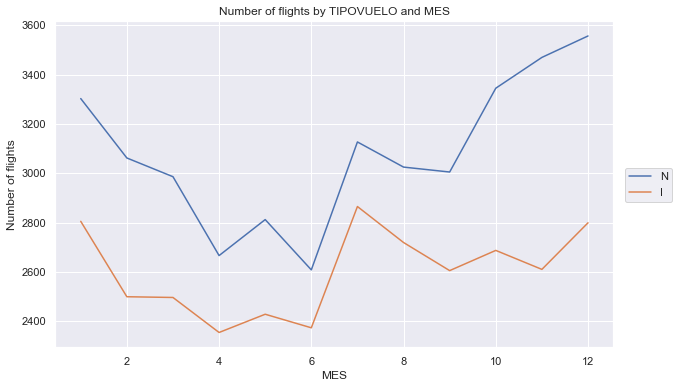

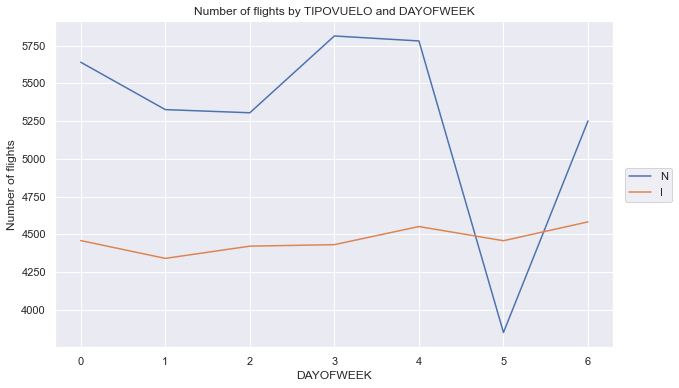

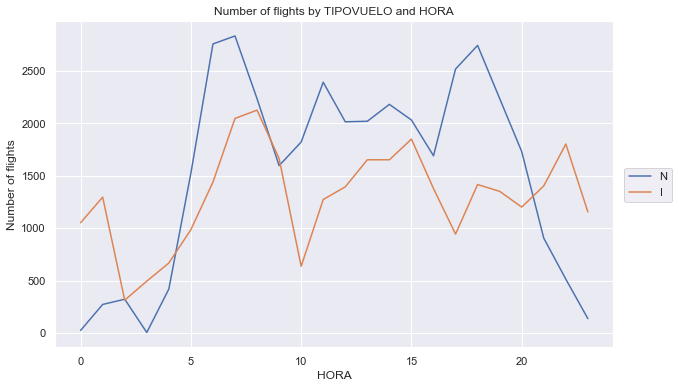

In [100]:
#Generate HORA and DAYOFWEEK column based on flight scheduled date
data['HORA'] = data['Fecha-I'].dt.hour
data['DAYOFWEEK'] = data['Fecha-I'].dt.dayofweek

time_columns = ['MES', 'DAYOFWEEK', 'HORA']

#Seasonality of domestic vs international flights

for time_col in time_columns:
    get_flight_seasonality_graph(data, time_col, 'TIPOVUELO')


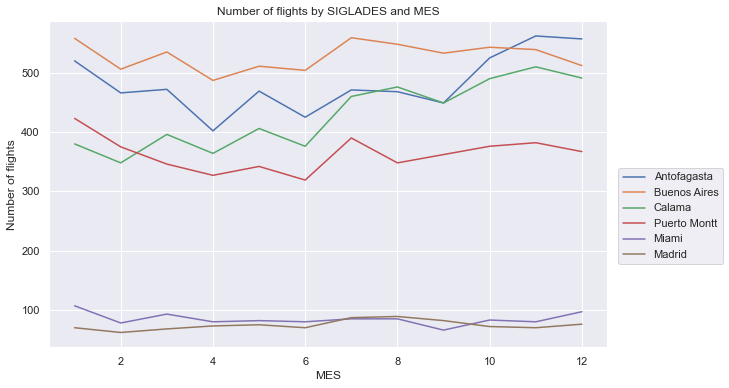

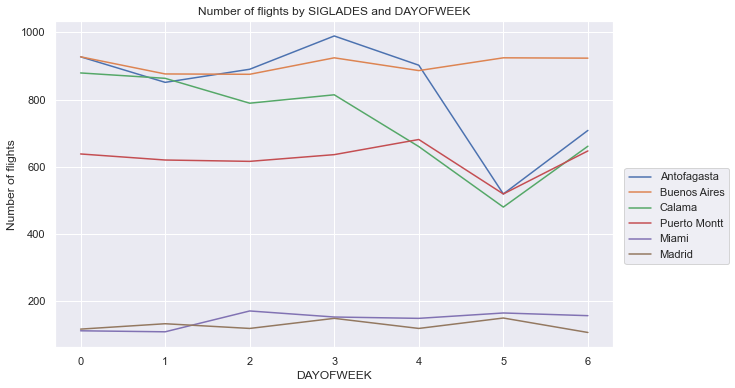

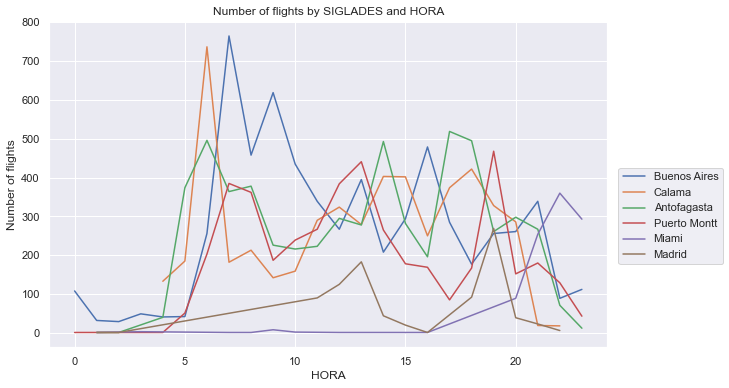

In [101]:
#Seasonality of selected destinations

destinations = ['Buenos Aires', 'Antofagasta', 'Calama', 'Puerto Montt', 'Miami', 'Madrid']

data_subset = data[data['SIGLADES'].isin(destinations)]

for time_col in time_columns:
    get_flight_seasonality_graph(data_subset, time_col, 'SIGLADES')

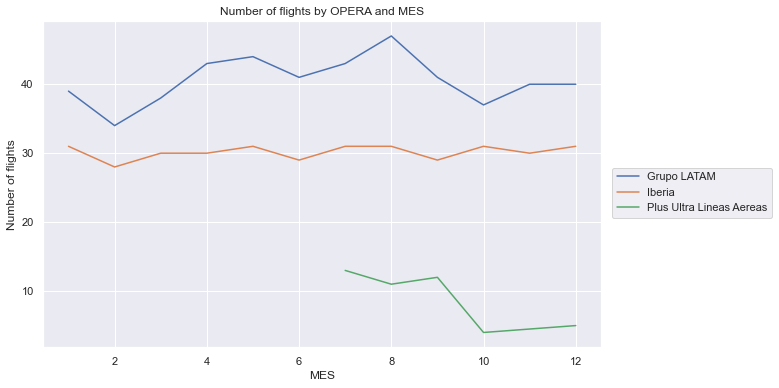

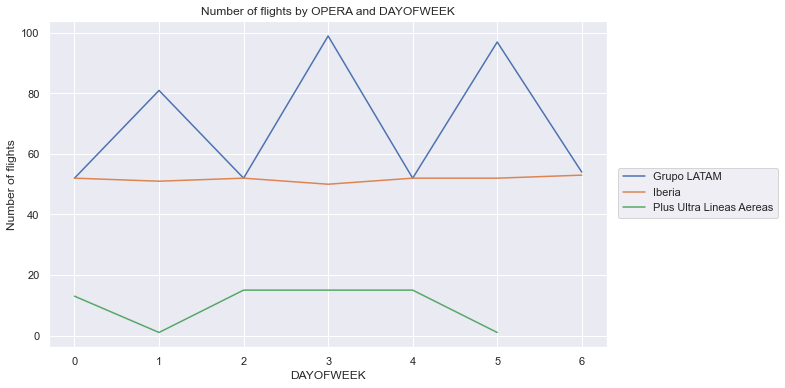

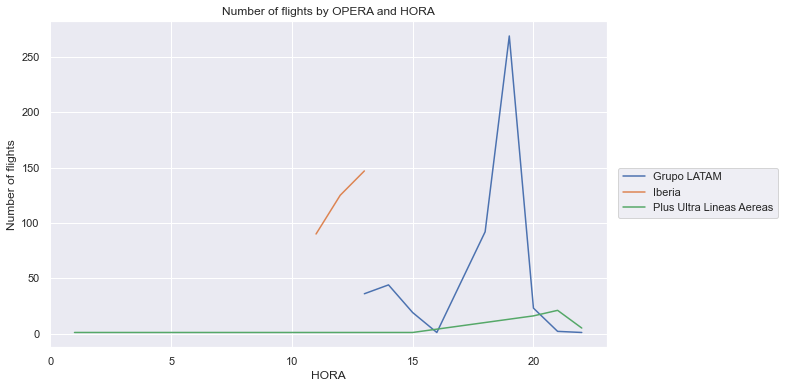

In [102]:
#Madrid bound flights by Airline
destinations = ['Madrid']

data_subset = data[data['SIGLADES'].isin(destinations)]

for time_col in time_columns:
    get_flight_seasonality_graph(data_subset, time_col, 'OPERA')

### 2. Question 2: Generate additional columns and export them to a CSV file.

In [103]:
#Generate high_season column:
#1 if Fecha-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
mask_high_season = (
                    ((data['Fecha-I'].dt.month == 12) &  (data['Fecha-I'].dt.day >= 15)) |    #Days between Dec-15 and Dec-31
                    (data['Fecha-I'].dt.month <= 2)                                      |    #January and February
                    ((data['Fecha-I'].dt.month == 3) & (data['Fecha-I'].dt.day <= 3))    |    #Days between Mar-1 and Mar-3
                    ((data['Fecha-I'].dt.month == 7) & (data['Fecha-I'].dt.day >= 15))   |    #Days between Jul-15 and Jul-31
                    ((data['Fecha-I'].dt.month == 9) & (data['Fecha-I'].dt.day >= 11))        #Days between Sep-11 and Sep-30
                )
data['high_season'] = 1 * mask_high_season

In [104]:
#Generate min_diff column: difference in minutes between Fecha-O and Fecha-I
data['min_diff'] = (data['Fecha-O']-data['Fecha-I']).dt.total_seconds()/60

#Generate delay_15 column : 1 if min_diff > 15, 0 if not
data['delay_15'] = 1 * (data['min_diff'] > 15)

In [105]:
#Generate period_day column: 

data['period_day'] = data['Fecha-I'].apply(get_period_day)

In [106]:
#Export to CSV
synthetic_features = ['high_season', 'min_diff', 'delay_15', 'period_day']
data[synthetic_features].to_csv('../data/synthetic_features.csv')

### 3. Question 3: What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?

Looking at delay rates across the different variables in our dataset we can see that:
- Destination (SIGLADES): 
    - Some destinations stand out immediatley: Flights to Quito, Puerto Stanley and Cochambamba have a 100% delay rate, while flights to Curitiba, Cataratas do Iguacu, Pisco and Washington have a 0% delay rate. Upon closer inspection, this destinations have a very low flight count (the highest being Curitiba with 3 flights), so, eventhough these destinations would be highly informative with our current dataset, the conclusions drawed from them would probably be wrong.

    - Destinations in Oceania (Sydney, Melbourne and Auckland) are among the ones with highest delay rates. Sydney flights are only operated by Qantas and nearly all Qantas flights have Sydney as a destination, so a flight departing for Sydney shouldn't give much extra information if we include the operator in the model. However, flights to Melbourne and Auckland are operated almost exclusively by Grupo LATAM, who has less than 20% delay rate among its flights, so this destinations should be highly informative.

    - All domestic destinations tend to have a lower delay rate than the average, but with little dispersion between them. Thus, this could be captured by the kind of flight variable.
    
    - Overall, destination should not be a highly informative variable for foreign operators but could be useful Chilean operators (as said earlier, foreign operators visit a very small number of destinations, as opposed to Chilean operators).

- Flight Operator (OPERA):
    - Flight Operator seems to have high potential as an explanatory variable, except for Grupo Latam and Sky Airline, both of which have the highest share of flights and, accordingly, have an average delay rate very close to the global mean.

    - In the case of Grupo LATAM and Sky Airline, destination could contribute more information due to their wide range of destinations.

- Month (MES):
    - Flights during July (probably associated to meteorologic conditions) and December stand out as the ones with the highest delay rate. On the contrary, flights during March and April have the lowest delay rate.
    
    - Eventhough the standout months correspond to high and off season, respectively, given that the rest of months have a pretty average behaviour, this variable should be more informative than the *high_season* indicator.

- Day of week (DAYOFWEEK):
    - There is not much dispersion among the delay rates of the different days of the week, so this variable should not convey much information.


- High season indicator (high_season):

    - There is not much difference in terms of delay rate between flights during the high and the off season. This confirms what was mentioned before, the *month* variable should be more informative and preferred to this indicator.


- Kind of flight (TIPOVUELO):
    - As was seen in the analysis of destinations, Domestic flights clearly have a lower delay rate than International ones. This variable should be highly informative.

Summing up, the variables with the highest potential as explanatory variables are Flight Operator and Kind of Flight. Having less potential than the previous ones but still having information that could help improve predictions are Destination and Month. Lastly, low potential variables are Day of Week and High Season indicator.

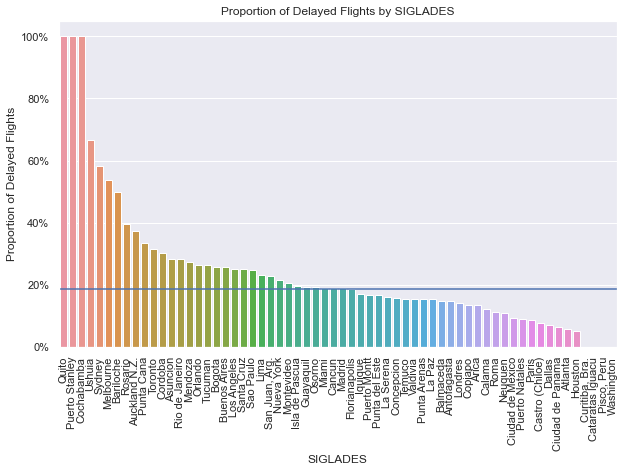

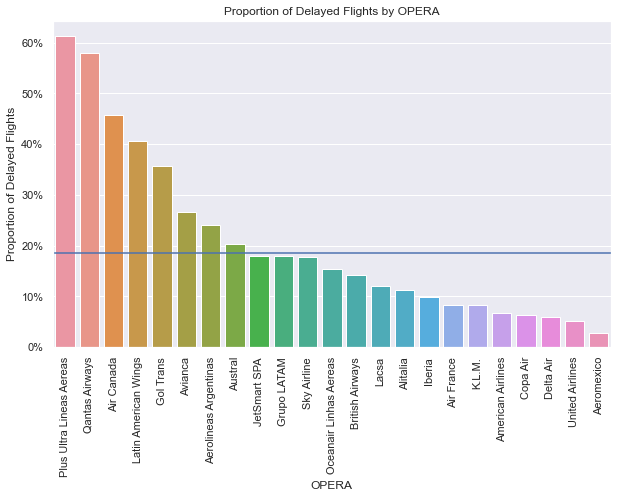

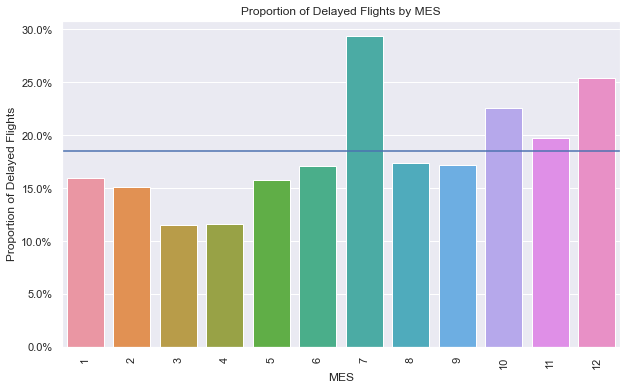

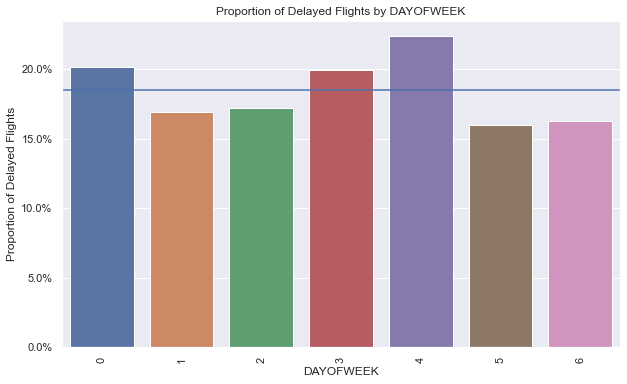

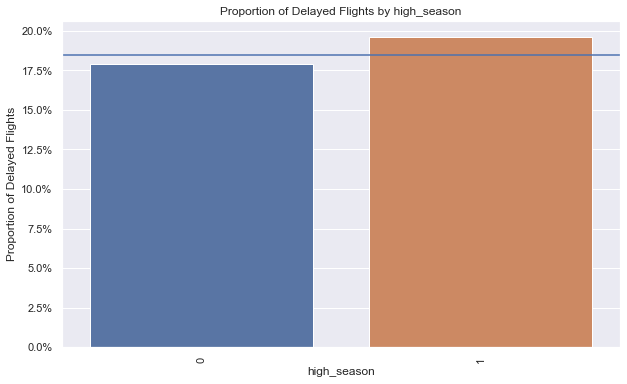

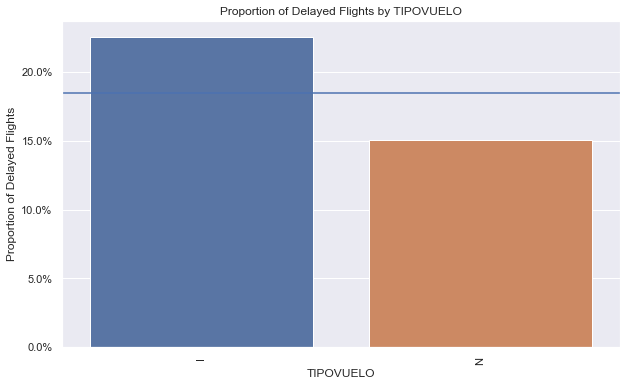

In [107]:
#Create delay rate plots by group

columns_to_plot = ['SIGLADES', 'OPERA', 'MES', 'DAYOFWEEK', 'high_season', 'TIPOVUELO']
for col in columns_to_plot:
    get_delay_rate_graph(data, col)

In [108]:
#Count of flights of outlier destinations
destinations = ['Quito', 'Puerto Stanley', 'Cochabamba', 'Curitiba, Bra.', 'Cataratas Iguacu', 'Pisco, Peru', 'Washington']
data['SIGLADES'].value_counts()[destinations]

Quito               2
Puerto Stanley      1
Cochabamba          1
Curitiba, Bra.      3
Cataratas Iguacu    2
Pisco, Peru         1
Washington          1
Name: SIGLADES, dtype: int64

In [109]:
#Count of flights to Oceania by operator
destinations = ['Sydney', 'Melbourne', 'Auckland N.Z.']
data[data['SIGLADES'].isin(destinations)][['SIGLADES','OPERA']].value_counts()

SIGLADES       OPERA         
Auckland N.Z.  Grupo LATAM       361
Sydney         Qantas Airways    194
Melbourne      Grupo LATAM        38
               Qantas Airways      1
dtype: int64

### 4. Question 4: Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.

One of the main reasons for flights being delayed are the knock-on effects, ie. late arrival of the plane to be used on the delayed flight. Considering these, one could think that companies would make extra efforts for flights operating from/to their hubs or operation bases to be on time.
Let's check if this can help us generate features that allow us to better predict delayed flights.

Since our dataset contains only values for flights taking off from SCL, all flights operated by Chilean companies (Grupo LATAM, Sky Airline, JetSmart SPA and Latin American Wings) will be taking off *from* their hub.

In [110]:
chilean_operators = ['Grupo LATAM', 'Sky Airline', 'Latin American Wings', 'JetSmart SPA']
data['from_hub'] = 1 * (data['OPERA'].isin(chilean_operators))

For foreign companies, let's make the assumption that their most frequent destination is the location of their hub:

In [111]:
foreign_hubs = data[~data['OPERA'].isin(chilean_operators)][['OPERA','SIGLADES']].value_counts().reset_index()
foreign_hubs = foreign_hubs.drop_duplicates('OPERA', keep='first')[['OPERA', 'SIGLADES']]
foreign_hubs

,OPERA,SIGLADES
0,Aerolineas Argentinas,Buenos Aires
1,Copa Air,Ciudad de Panama
2,Avianca,Bogota
3,Gol Trans,Sao Paulo
4,American Airlines,Miami
5,Iberia,Madrid
6,Air France,Paris
7,Delta Air,Atlanta
9,Aeromexico,Ciudad de Mexico
10,United Airlines,Houston


A quick Google search validates our assumption for most cases with the exception of KLM (KLM flights make a layover in EZE before flying to AMS), Lacsa (their flights have Central America as final destination and make a layover in Lima) and Austral (subsidiary of Aerolineas Argentinas that has Buenos Aires as home base), so our assumption is good enough. Let's flag the flights by foreign companies *to* their hubs:

In [112]:
data['to_hub'] = 1 * data.apply(lambda x: get_to_hub_flag(x, foreign_hubs), axis = 1)


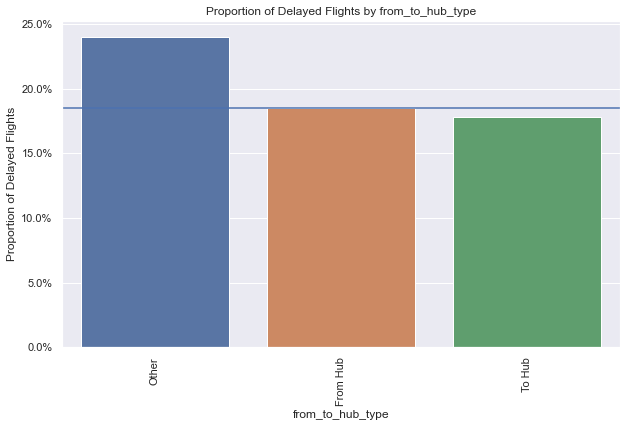

In [113]:
#Graph delay rate by to/from hub type
data['from_to_hub_type'] = 'Other'
data.loc[(data['from_hub'] == 1), 'from_to_hub_type'] = 'From Hub'
data.loc[(data['to_hub'] == 1), 'from_to_hub_type'] = 'To Hub'
data.drop(['from_hub', 'to_hub'], axis = 1, inplace= True)
get_delay_rate_graph(data, 'from_to_hub_type')

According to the graph, flights *from* a hub have a similar delay rate as the general mean (not surprisingly, since most of our data are flights operated by Grupo LATAM and Sky Airline). On the other hand, flights made *to* a hub appear to have a slightly lower delay rate and flights that are neither *from* or *to* a hub have significantly higher delay rate. This suggests that these variables could have some influence on predicting delays, so they will be included in our tests.

- Before diving into the ML process let's make some definitions:
    
    - Target variable: *delay_15*, we are trying to predict if any given flight will be delayed or not.
    
    - Features to be used: *OPERA* (Flight Operator), *SIGLADES* (Flight Destination), *period_day* (Period of day of scheduled take-off), *MES*, *DIANOM* (Month and Day of Week when the flight ocurred), *TIPOVUELO* (Domestic or International Flight indicator), *from_to_hub_type* (indicates if flight was made from or to the operator's hub, or neither).

    - Train-test split: We will use a typical 80-20 split.

    - Models to be tested:
        
        - Logistic Regression (LR): One of the classical models to predict probabilities. It's simplicity provides explainability and fast run times.

        - Random Forest (RF): Pooling the results of a set of different decision trees, trained with different subsets of the data and using different features in different orders gives better results than just using one simple tree. Also helps with over-fitting.

        - XGBoost (XGB): One of the most popular algorithms out there, uses gradient boosting decision trees to try and correct errors made by previous trees in the chain of models. Fast and achieves high performances.

        - Multi Layer Perceptron Classifier (MLP): We will test a small neural network just to check if a more complex model outperforms tree-based models and LR.

- We also know that just 18.5% of flights are delayed which indicates that we are facing an **imbalanced classification problem**. In order to overcome this problem we will use two strategies:
    
    - Resampling: We will use a combination of over-sampling and under-sampling by preprocessing our dataset using *imbalanced-learn*'s *SMOTEENN*, which combines over-sampling by applying the *SMOTE* technique and under-sampling by applying the *Estimated Nearest Neighbours* technique.
    
    - Evaluation Metric: Since using classical *accuracy* as the evaluation metric would yield over 80% accuracy for a naive classifier that just labels every flight as not delayed, we will train our models using the F1-Score metric.

- With all this in place, let's move forward:

In [114]:
#Preprocessing & Train-Test split

feature_names = ['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'period_day', 'from_to_hub_type']
target_name = 'delay_15'

X = data[feature_names]
y = data[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#All our features are categorical, so we have to encode them
encoder = OneHotEncoder(min_frequency=5, sparse_output = False, handle_unknown='ignore') #Drop infrequent categories, like Quito as a destination.
encoder.fit(X_train)

X_train = encode_feats(encoder, X_train)
X_test = encode_feats(encoder, X_test)


In [115]:
#Resampling

#Check distribution pre-resampling
print(y_train.value_counts(normalize=True))

smote_enn = SMOTEENN(random_state=0)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

#Check distribution post-resampling
print(y_train_resampled.value_counts(normalize = True))

0    0.815061
1    0.184939
Name: delay_15, dtype: float64
0    0.649411
1    0.350589
Name: delay_15, dtype: float64


In [116]:
#Initialize fitted model list
fitted_models = []


In [117]:
lr = LogisticRegression(random_state=0, max_iter = 1000)

param_grid = [
    {'penalty': [None,'l1'],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'class_weight': [None, 'balanced']}
]

t0 = time.time()

best_lr = get_best_model_CV(X_train_resampled, y_train_resampled , lr, param_grid=param_grid)

tf = time.time()

fitted_models.append({'name': 'Logistic Regression',
    'fitted_model': best_lr,
    'training_time': tf-t0,}
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [118]:
rf = RandomForestClassifier(random_state=0)

param_grid = [
    {'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy', 'log-loss'],
    'max_depth': [None, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']}
]

t0 = time.time()

best_rf = get_best_model_CV(X_train_resampled, y_train_resampled , rf, param_grid=param_grid)

t1 = time.time()

fitted_models.append({'name': 'Random Forest',
    'fitted_model': best_rf,
    'training_time': tf-t0,
})

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [119]:
xgb_clf = xgb.XGBClassifier(random_state=0)

param_grid = [
    {'n_estimators': [50, 100, 200],
    'max_depth': [6, 10, 15],}
]

t0 = time.time()

best_xgb = get_best_model_CV(X_train_resampled, y_train_resampled , xgb_clf, param_grid=param_grid)

t1 = time.time()

fitted_models.append({'name': 'XGBoost',
    'fitted_model': best_xgb,
    'training_time': tf-t0,
})

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [121]:
mlp_clf = MLPClassifier(random_state=0, max_iter = 300)

param_grid = [
    {'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam'],
    'early_stopping': [True],
    'hidden_layer_sizes' : [(100,3)]}
]

t0 = time.time()

best_mlp = get_best_model_CV(X_train_resampled, y_train_resampled , mlp_clf, param_grid=param_grid)

t1 = time.time()

fitted_models.append({'name': 'MLP Classifier',
    'fitted_model': best_mlp,
    'training_time': tf-t0,
})

Fitting 5 folds for each of 3 candidates, totalling 15 fits
